In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from collections import Counter
import requests
import zipfile
import io
import matplotlib.pyplot as plt

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
# Download and Prepare the Corpus
# Download the text8 dataset and limit it to 1 million characters for simplicity.
url = "http://mattmahoney.net/dc/text8.zip"
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    text = z.read("text8").decode("utf-8")
text = text[:1000000]  # Limit to 1M characters
words = text.split()
print(f"Corpus size: {len(words)} words")

Corpus size: 167285 words


In [3]:
# Build Vocabulary and Pairs
# Create the vocabulary and generate positive skip-gram pairs.
vocab = list(set(words))
vocab_size = len(vocab)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
print(f"Vocabulary size: {vocab_size}")

# Compute sampling probabilities for negative sampling
word_freq = Counter(words)
freq_array = np.array([word_freq[word] for word in vocab])
sampling_weights = freq_array ** 0.75
sampling_probs = sampling_weights / sampling_weights.sum()

# Generate positive pairs
window_size = 5
pairs = []
for i in range(len(words)):
    for j in range(max(0, i - window_size), min(len(words), i + window_size + 1)):
        if i != j:
            pairs.append((word_to_idx[words[i]], word_to_idx[words[j]]))
print(f"Number of pairs: {len(pairs)}")

Vocabulary size: 16774
Number of pairs: 1672820


In [4]:
# Define the Skip-Gram Model
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Embedding(vocab_size, embedding_dim)
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.5 / embedding_dim
        self.embeddings.weight.data.uniform_(-initrange, initrange)
        self.out_layer.weight.data.uniform_(-initrange, initrange)
    
    def forward(self, target, positive_context, negative_contexts):
        target_emb = self.embeddings(target)
        pos_emb = self.out_layer(positive_context)
        neg_emb = self.out_layer(negative_contexts)
        
        # Positive loss
        pos_score = torch.sum(target_emb * pos_emb, dim=1)
        pos_loss = -torch.log(torch.sigmoid(pos_score)).mean()
        
        # Negative loss
        neg_score = torch.bmm(neg_emb, target_emb.unsqueeze(2)).squeeze(2)
        neg_loss = -torch.log(torch.sigmoid(-neg_score)).mean()
        
        return pos_loss + neg_loss

In [5]:
class SkipGramDataset(Dataset):
    def __init__(self, pairs, vocab_size, sampling_probs, k=5):
        self.pairs = pairs
        self.vocab_size = vocab_size
        self.sampling_probs = sampling_probs  # NumPy array or list
        self.k = k

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        target, positive = self.pairs[idx]
        # Sample negative contexts on CPU, then move to device
        negative = np.random.choice(self.vocab_size, self.k, p=self.sampling_probs)
        return (
            torch.tensor(target, device=device),
            torch.tensor(positive, device=device),
            torch.tensor(negative, device=device)
        )

# Initialize dataset and dataloader
dataset = SkipGramDataset(pairs, vocab_size, sampling_probs, k=5)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
# Initialize Model 
embedding_dim = 100
model = SkipGramModel(vocab_size, embedding_dim).to(device)

# Define Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
from tqdm import tqdm
import os

# Directory to save checkpoints
checkpoint_dir = "checkpoints"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Train the model
num_epochs = 5
loss_history = []
for epoch in range(num_epochs):
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, batch in enumerate(progress_bar):
        target, positive_context, negative_contexts = batch
        optimizer.zero_grad()
        loss = model(target, positive_context, negative_contexts)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': total_loss / (i + 1)})
    
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pt")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss / len(dataloader),
    }, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    loss_history.append(avg_loss)
    

Epoch 1/5: 100%|███████████████| 52276/52276 [31:10<00:00, 27.94it/s, loss=1.25]


Checkpoint saved to checkpoints/model_epoch_1.pt
Epoch 1, Loss: 1.2532


Epoch 2/5: 100%|███████████████| 52276/52276 [30:43<00:00, 28.36it/s, loss=1.14]


Checkpoint saved to checkpoints/model_epoch_2.pt
Epoch 2, Loss: 1.1383


Epoch 3/5: 100%|███████████████| 52276/52276 [30:09<00:00, 28.89it/s, loss=1.04]


Checkpoint saved to checkpoints/model_epoch_3.pt
Epoch 3, Loss: 1.0419


Epoch 4/5: 100%|██████████████| 52276/52276 [30:21<00:00, 28.69it/s, loss=0.973]


Checkpoint saved to checkpoints/model_epoch_4.pt
Epoch 4, Loss: 0.9732


Epoch 5/5: 100%|██████████████| 52276/52276 [29:41<00:00, 29.35it/s, loss=0.928]


Checkpoint saved to checkpoints/model_epoch_5.pt
Epoch 5, Loss: 0.9280


In [25]:
# Load the checkpoint
checkpoint_path = "checkpoints/model_epoch_5.pt"  
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']

# Resume training from the next epoch
for epoch in range(start_epoch, num_epochs + 5):
    total_loss = 0
    # Wrap the dataloader with tqdm to show progress for batches
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, batch in enumerate(progress_bar):
        target, positive_context, negative_contexts = batch
        optimizer.zero_grad()
        loss = model(target, positive_context, negative_contexts)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        # Update the progress bar with the running average loss
        progress_bar.set_postfix({'loss': total_loss / (i + 1)})
    
    # Save the model checkpoint after each epoch
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pt")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss / len(dataloader),
    }, checkpoint_path)
    print(f"Checkpoint saved to {checkpoint_path}")
    
    # Print the final average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")
    loss_history.append(avg_loss)

Epoch 6/5: 100%|██████████████| 52276/52276 [29:47<00:00, 29.25it/s, loss=0.899]


Checkpoint saved to checkpoints/model_epoch_6.pt
Epoch 6, Loss: 0.8986


Epoch 7/5: 100%|██████████████| 52276/52276 [29:32<00:00, 29.49it/s, loss=0.879]


Checkpoint saved to checkpoints/model_epoch_7.pt
Epoch 7, Loss: 0.8793


Epoch 8/5: 100%|██████████████| 52276/52276 [30:56<00:00, 28.16it/s, loss=0.866]


Checkpoint saved to checkpoints/model_epoch_8.pt
Epoch 8, Loss: 0.8663


Epoch 9/5: 100%|██████████████| 52276/52276 [33:10<00:00, 26.27it/s, loss=0.857]


Checkpoint saved to checkpoints/model_epoch_9.pt
Epoch 9, Loss: 0.8566


Epoch 10/5: 100%|██████████████| 52276/52276 [31:51<00:00, 27.35it/s, loss=0.85]


Checkpoint saved to checkpoints/model_epoch_10.pt
Epoch 10, Loss: 0.8500


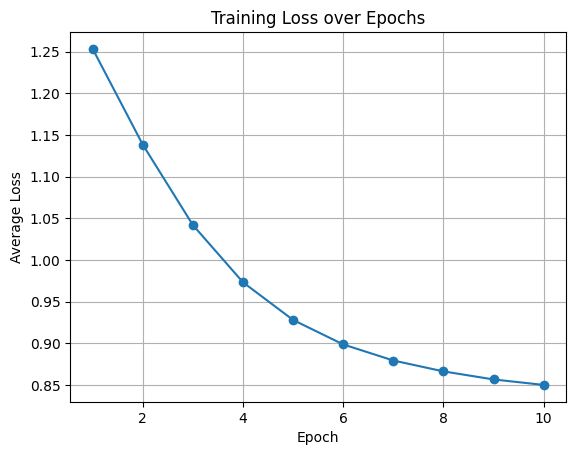

In [28]:
plt.plot(range(1, num_epochs + 6), loss_history, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()